In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from keras.callbacks import EarlyStopping
from datetime import datetime
import mlflow
import mlflow.pyfunc
import yaml

2023-11-05 13:55:56.156573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 13:55:56.211173: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 13:55:56.211205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 13:55:56.211220: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 13:55:56.217888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 13:55:56.218516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
from libs.ts_forecasting import *
from libs.postgres_functions import *

In [3]:
# Load general configurations
with open('config/general_config.yaml', 'r') as file:
    general_config = yaml.safe_load(file)

# Load project-specific configurations
with open('config/project_config.yaml', 'r') as file:
    project_config = yaml.safe_load(file)

In [4]:
print("General Configurations Loaded:\n")
print(general_config)

General Configurations Loaded:

{'model_name': 'dummy_data', 'model_artifact_name': 'TSMixerModel3', 'experiment_version': '1.1', 'production_version': '1.1', 'features': ['inflacion', 'leliqs'], 'csv_paths': ['datasets/inflacion.csv', 'datasets/leliqs.csv'], 'register_experiment': False, 'register_model': False, 'train_size': 0.8, 'epochs': 50, 'batch_size': 8, 'patience': 5, 'look_back': 10, 'stage': 'Production'}


In [5]:
print("\nProject Level Configurations Loaded:\n")
print(project_config)


Project Level Configurations Loaded:

{'years': [2019, 2020, 2021, 2022, 2023], 'points_per_year': [10, 10, 10, 10, 8]}


# Data Loading

In [6]:
# List to contain the datasets we load
dataframe_list = []

# Inflation

https://es.tradingeconomics.com/argentina/inflation-cpi#calendar-table

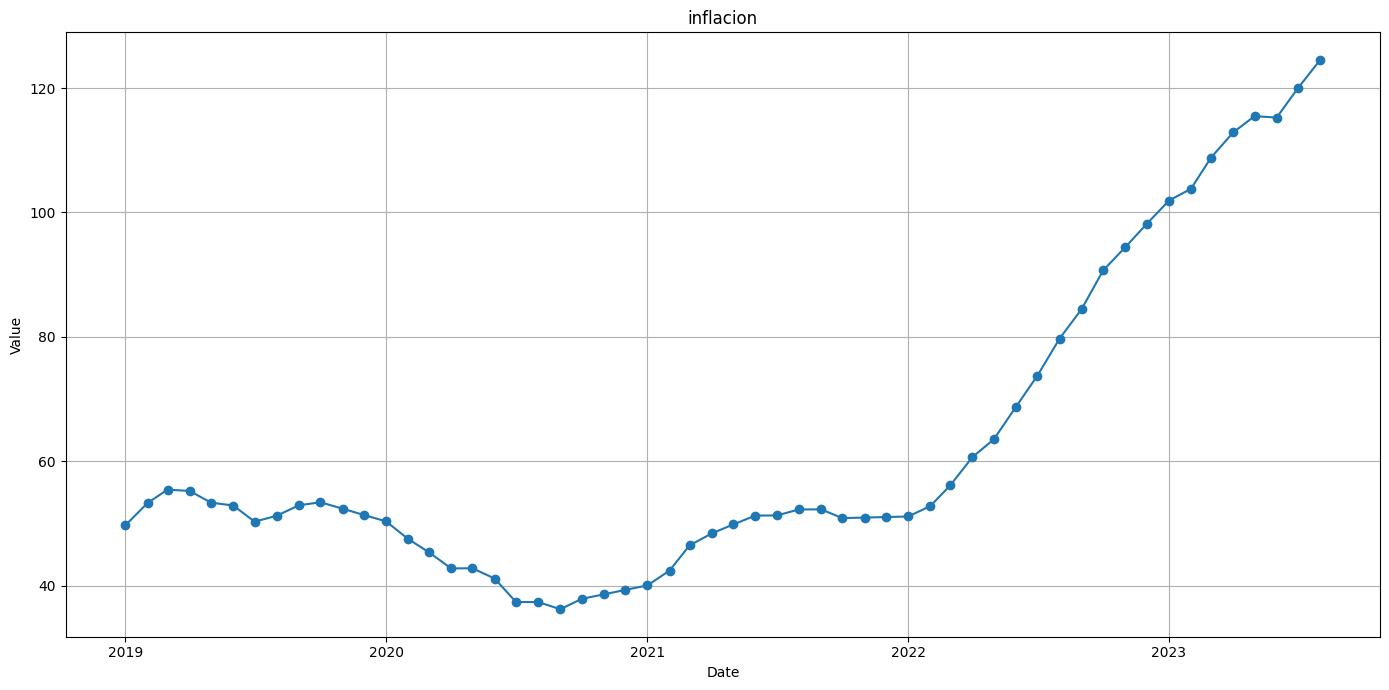

In [7]:
data_1 = load_and_preprocess_data(general_config['csv_paths'][0], 
                                  general_config['features'][0], 
                                  project_config['years'], 
                                  project_config['points_per_year'])
dataframe_list.append(data_1)
plot_loaded_data(data_1, general_config['features'][0], "Value")

# LELIQs

https://www.estadisticasbcra.com/leliq#:~:text=%23%23%23%23%20%C3%9Altimo%0A%0A%23%23%23%2015084400%0A%0A2023

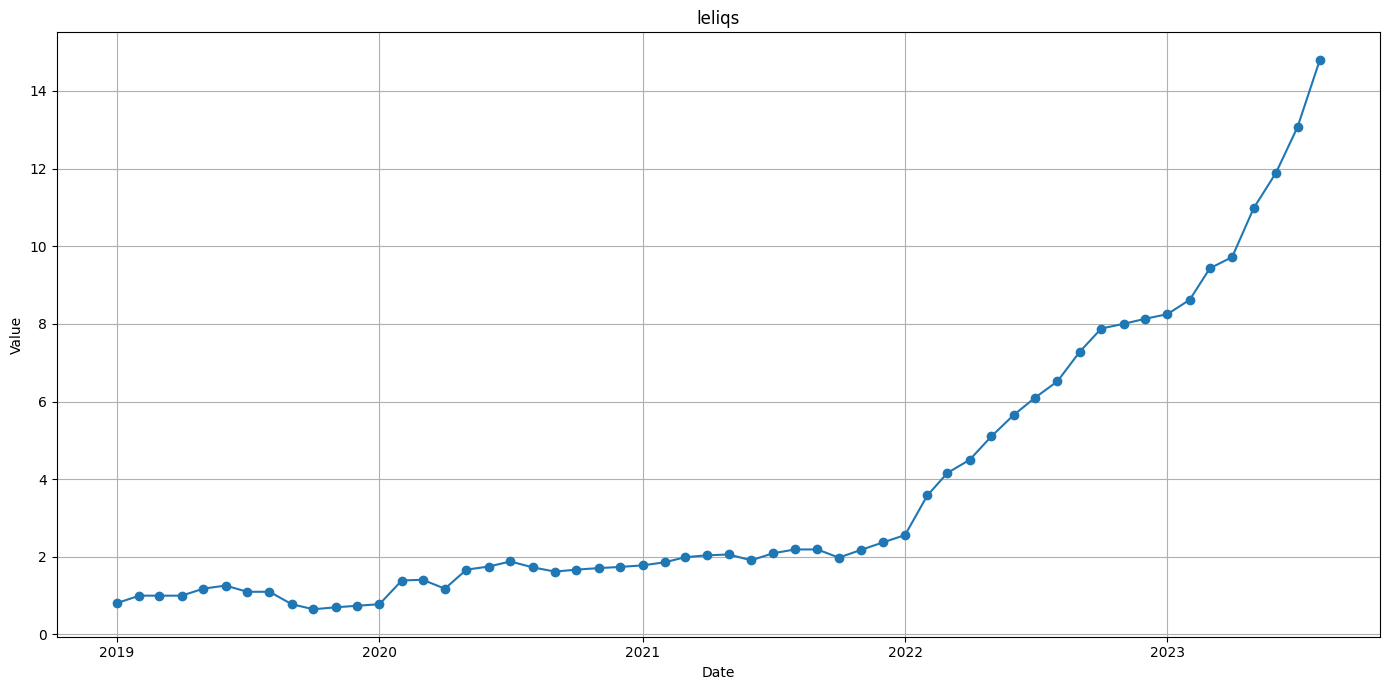

In [8]:
data_2 = load_and_preprocess_data(general_config['csv_paths'][1], 
                                  general_config['features'][1], 
                                  project_config['years'], 
                                  project_config['points_per_year'])

# Special pre processing for this data
data_2[general_config['features'][1]] = (data_2[general_config['features'][1]] / 1e6).round(2)

dataframe_list.append(data_2)
plot_loaded_data(data_2, general_config['features'][1], "Value")

In [9]:
# Combine data for model training
combined_dataframe = pd.concat(dataframe_list, axis=1)
data = combined_dataframe.copy()
data.columns = general_config['features']

# Keep a copy of the original data for later purposes
data_original = data.copy()

In [10]:
data.head()

,inflacion,leliqs
2019-01-01,49.704,0.81
2019-02-01,53.283,1.00
2019-03-01,55.442,1.00
2019-04-01,55.223,1.00
2019-05-01,53.346,1.18


# Scaling

In [11]:
# Scale the data
data, data_scalers = scale_data(data)

# Modelling

In [12]:
# Train and Test Set Creation:
X_train, X_test, Y_train, Y_test, X, Y = train_test_time_based_split(np.array(data), 
                                                                     general_config['look_back'], 
                                                                     general_config['train_size'])

In [13]:
# Create the TSMixer-inspired model
tsmixer_model = build_tsmixer_model(input_shape=(general_config['look_back'], 
                                                 len(general_config['features'])), 
                                    num_features=len(general_config['features']))
tsmixer_model.compile(optimizer='adam', loss='mean_squared_error')
tsmixer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 2)]           0         
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 reshape (Reshape)           (None, 10, 2)             0         
                                                                 
 flatten_1 (Flatten)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dense_2 (Dense)             (None, 2)                 102   

Epoch 1/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0561 - val_loss: 0.5151
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0282 - val_loss: 0.2525
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0754
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0135
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0055
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0057
Epoch 10/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 10: early stopping


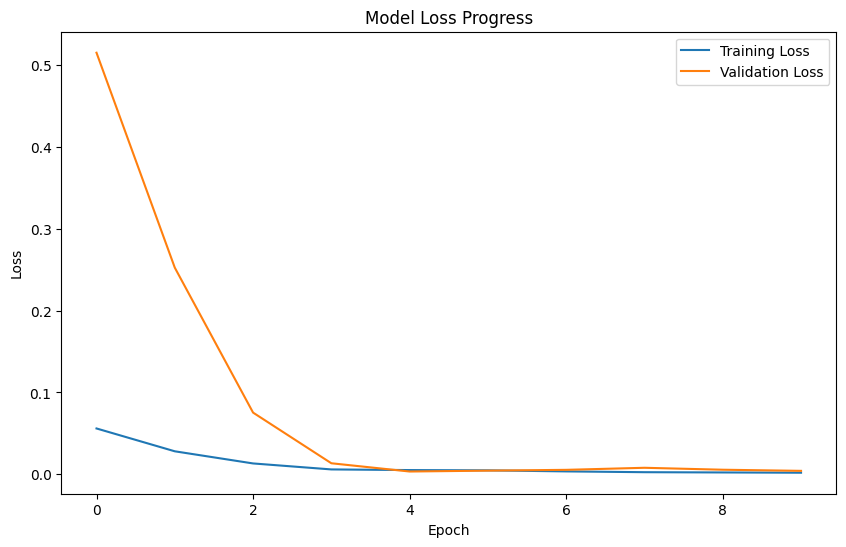

In [14]:
# Train the model
history = train_tsmixer_model(tsmixer_model, X_train, Y_train, X_test, Y_test, 
                              epochs=general_config['epochs'], 
                              batch_size=general_config['batch_size'], 
                              patience=general_config['patience'])

1/1 [==============================] - 0s 49ms/step


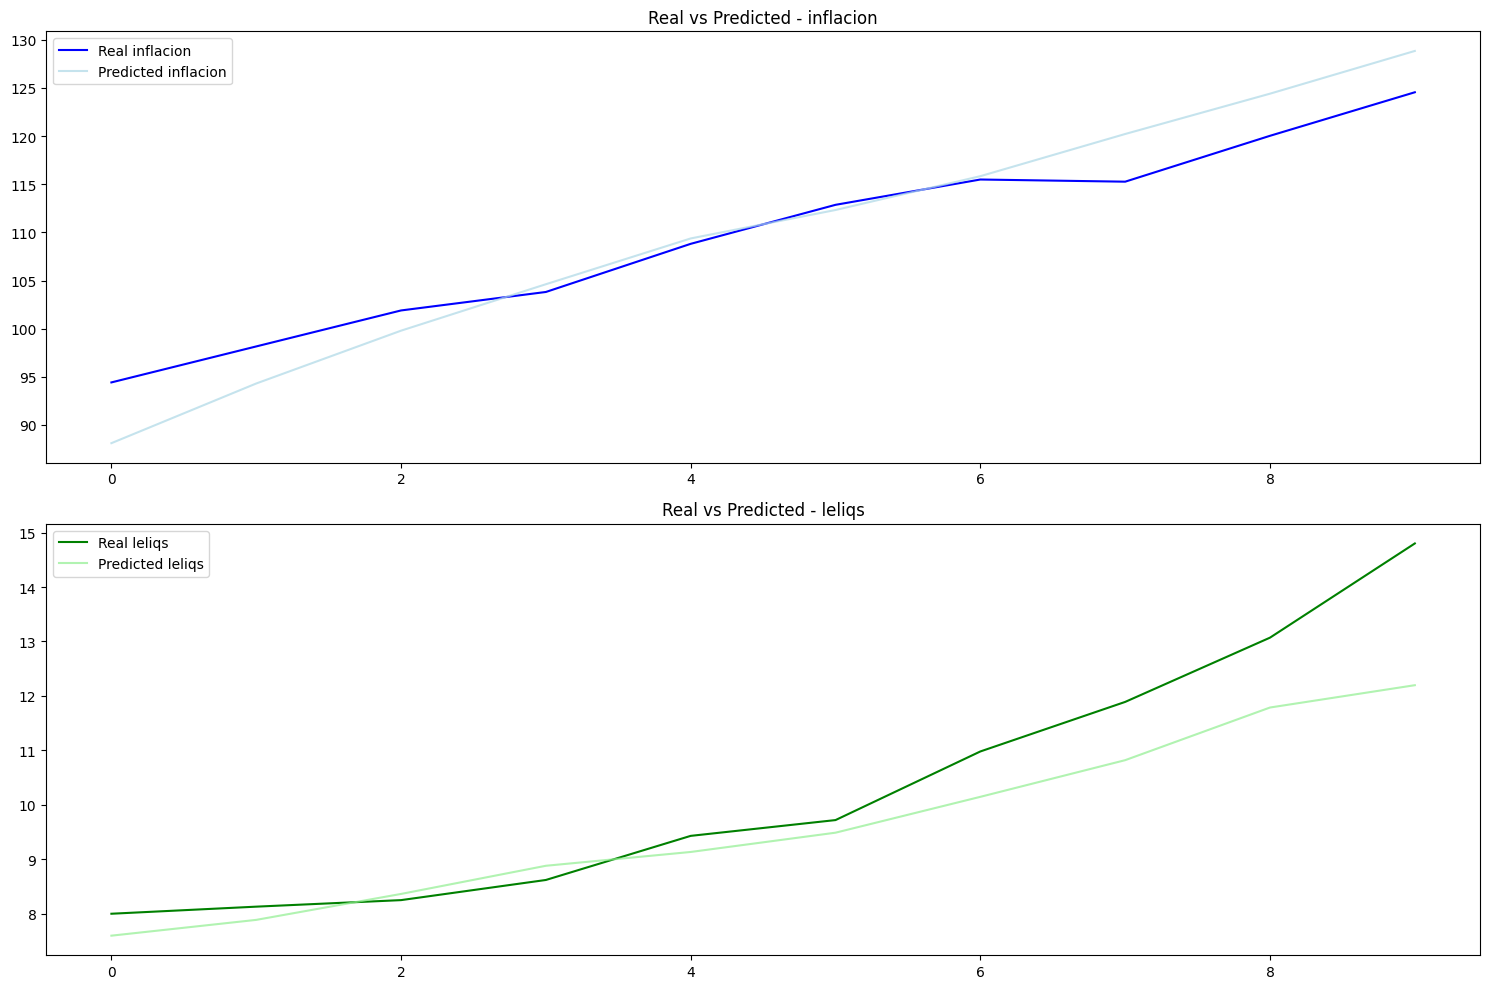

In [15]:
# Make predictions over the test set
Y_test_original, predictions_original, predictions = predict_test_set(tsmixer_model, X_test, Y_test, 
                                                                      data_scalers, general_config['features'])

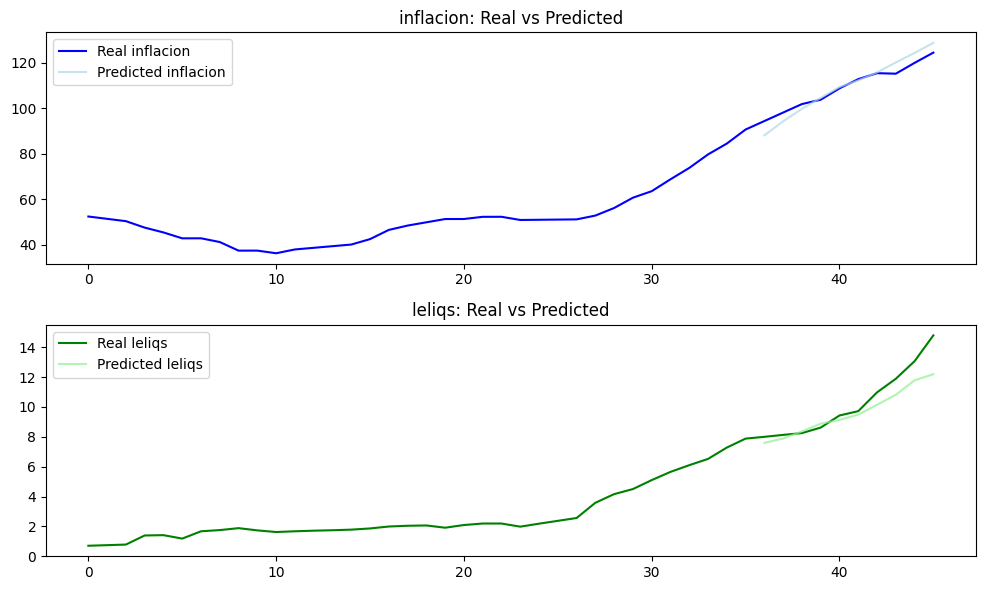

In [16]:
# Plot the test set predictions with the history of the time series
plot_test_set_predictions_with_history(Y_train, Y_test, predictions, data_scalers, general_config['features'])

In [17]:
# Metrics for the Test Set:
print("\n[Test Set] Evaluation:")
test_set_metrics = evaluate_test_set(Y_test, predictions, data_scalers, general_config['features'])


[Test Set] Evaluation:
inflacion - MAE: 2.812091284179684, RMSE: 3.49913877676204, MAPE: 2.611321064275903%
leliqs - MAE: 0.733613433837891, RMSE: 1.0346047289279705, MAPE: 6.192977373824406%


# Backtesting

1/1 [==============================] - 0s 10ms/step


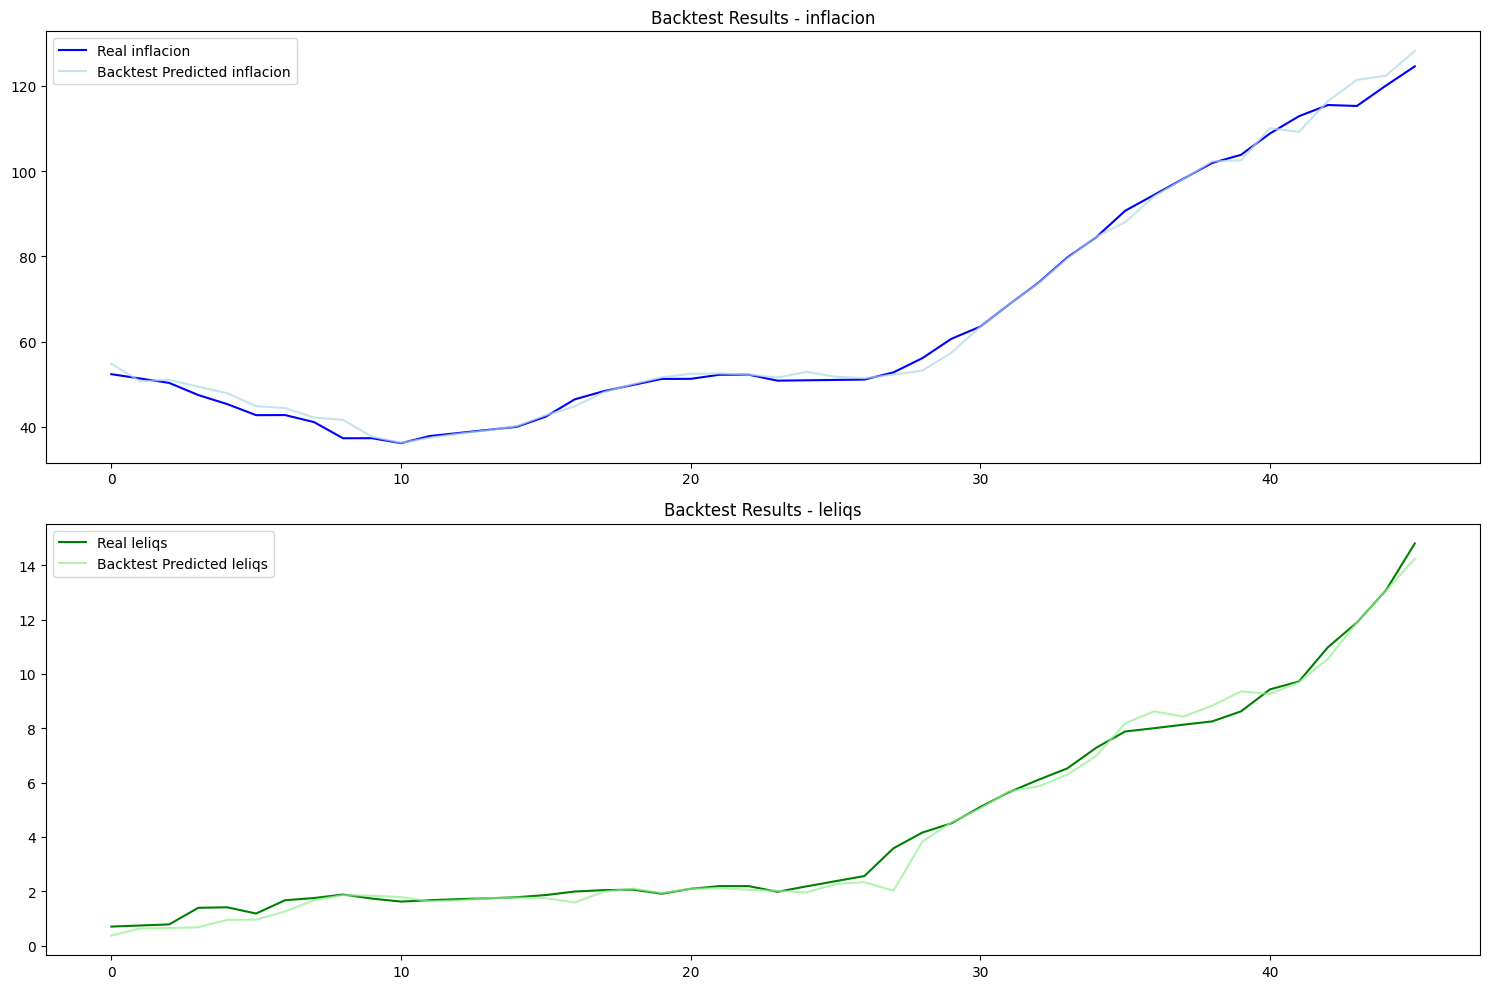

In [18]:
# Apply backtesting
predictions_bt, true_values_bt = backtest_model(tsmixer_model, X, Y, general_config['features'], data_scalers,
                                                plot_results=True, epochs=general_config['epochs'], 
                                                batch_size=general_config['batch_size'],
                                                patience=general_config['patience'])

In [19]:
# Use the evaluate function for backtesting results
print("\n[Backtest] Evaluation:")
metrics_bt = evaluate_test_set(true_values_bt, predictions_bt, data_scalers, general_config['features'])


[Backtest] Evaluation:
inflacion - MAE: 1.2296646606887593, RMSE: 1.8297076857090733, MAPE: 2.0024935959272656%
leliqs - MAE: 0.23545891393785892, RMSE: 0.36641393772132463, MAPE: 8.905626786739713%


# Future Forecast (beyond Test Set)

In [20]:
# Forecast with Production model:
forecasted_col_names = [f"forecasted_{feature}" for feature in general_config['features']]
forecasted_df = forecast_data(tsmixer_model, data, general_config['look_back'], 12, 
                              data_scalers, general_config['features'], columns=forecasted_col_names)

1/1 [==============================] - 0s 11ms/step


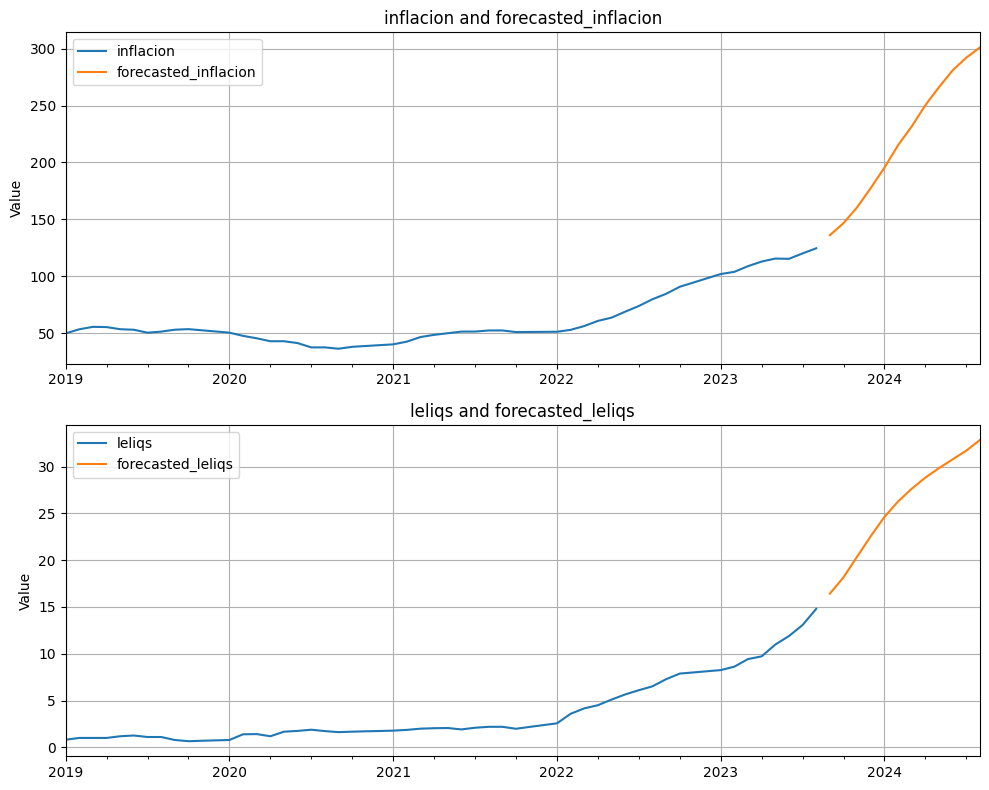

In [21]:
# Plot the forecast with history
history_and_forecast_df = pd.concat([data_original, forecasted_df], axis=0)
plot_future_forecast_with_history(history_and_forecast_df, general_config['features'])

# MLFlow Experiment Registration

In [ ]:
# MLFlow Experiment Registration and model saving

# MLFlow Configuration
metrics_to_log = {
    "Inflation - TestSet - MAE": test_set_metrics['inflacion_MAE'],
    "LELIQs - TestSet - MAE": test_set_metrics['leliqs_MAE'],
    "Inflation - TestSet - RMSE": test_set_metrics['inflacion_RMSE'],
    "LELIQs - TestSet - RMSE": test_set_metrics['leliqs_RMSE'],
    "Inflation - TestSet - MAPE": test_set_metrics['inflacion_MAPE'],
    "LELIQs - TestSet - MAPE": test_set_metrics['leliqs_MAPE'],
    "Inflation - Backtesting - MAE": metrics_bt['inflacion_MAE'],
    "LELIQs - Backtesting - MAE": metrics_bt['leliqs_MAE'],
    "Inflation - Backtesting - RMSE": metrics_bt['inflacion_RMSE'],
    "LELIQs - Backtesting - RMSE": metrics_bt['leliqs_RMSE'],
    "Inflation - Backtesting - MAPE": metrics_bt['inflacion_MAPE'],
    "LELIQs - Backtesting - MAPE": metrics_bt['leliqs_MAPE']
}

artifacts_to_log = ["plots/training_loss_plot.png", 
                    "plots/test_set_predictions.png", 
                    "plots/backtesting_predictions.png", 
                    "plots/future_forecast.png"]

if general_config['register_experiment']:
    log_experiment_to_mlflow(tsmixer_model, general_config['model_name'], 
                             general_config['experiment_version'], general_config['model_artifact_name'],
                             general_config['epochs'], general_config['batch_size'], 
                             metrics_to_log, artifacts_to_log, history_and_forecast_df)
    
    print("Experiment Registered!")

# Loading Favorite Experiment Model:

In [ ]:
# Loading Favorite Experiment Model:
favorite_run_id = '06663277c6ba4300bbfd5803e1cca34e'
tsmixer_model = load_mlflow_experimental_model(favorite_run_id, general_config['model_artifact_name'])
print(tsmixer_model)

# Registering Model

In [ ]:
if general_config['register_model']:
    mlflow.register_model(f"runs:/{favorite_run_id}/{general_config['model_artifact_name']}", 
                          f"{general_config['model_name']}_v{general_config['production_version']}")
    print("Model Registered!")

# Fetching the MLflow Model from the Model Registry

In [ ]:
# Loading Staged Model:

tsmixer_model = load_mlflow_staged_model(general_config['model_name'], 
                                         general_config['production_version'], 
                                         general_config['stage'])
print(tsmixer_model)

# Check Model with Forecast again

In [ ]:
# Forecast with Production model:
forecasted_col_names = [f"forecasted_{feature}" for feature in general_config['features']]
forecasted_df = forecast_data(tsmixer_model, data, general_config['look_back'], 12, 
                              data_scalers, general_config['features'], columns= forecasted_col_names)

# Plot the forecast with history
history_and_forecast_df = pd.concat([data_original, forecasted_df], axis=0)
plot_future_forecast_with_history(history_and_forecast_df, general_config['features'])

# Write to Postgres

In [22]:
save_to_postgres(history_and_forecast_df, 'history_and_forecast_test_1', mode='replace')

"DataFrame successfully saved to history_and_forecast_test_1 in PostgreSQL using mode 'replace'."

In [23]:
df = read_from_postgres('history_and_forecast_test_1')

Successfully loaded table 'history_and_forecast_test_1' from PostgreSQL.
Number of records: 68
Columns: index, inflacion, leliqs, forecasted_inflacion, forecasted_leliqs


In [24]:
df

,index,inflacion,leliqs,forecasted_inflacion,forecasted_leliqs
0,2019-01-01,49.704,0.81,NaN,NaN
1,2019-02-01,53.283,1.00,NaN,NaN
2,2019-03-01,55.442,1.00,NaN,NaN
3,2019-04-01,55.223,1.00,NaN,NaN
4,2019-05-01,53.346,1.18,NaN,NaN
...,...,...,...,...,...
63,2024-04-01,NaN,NaN,250.43147,28.832134
64,2024-05-01,NaN,NaN,266.35486,29.847734
65,2024-06-01,NaN,NaN,281.06778,30.778118
66,2024-07-01,NaN,NaN,292.24298,31.716377


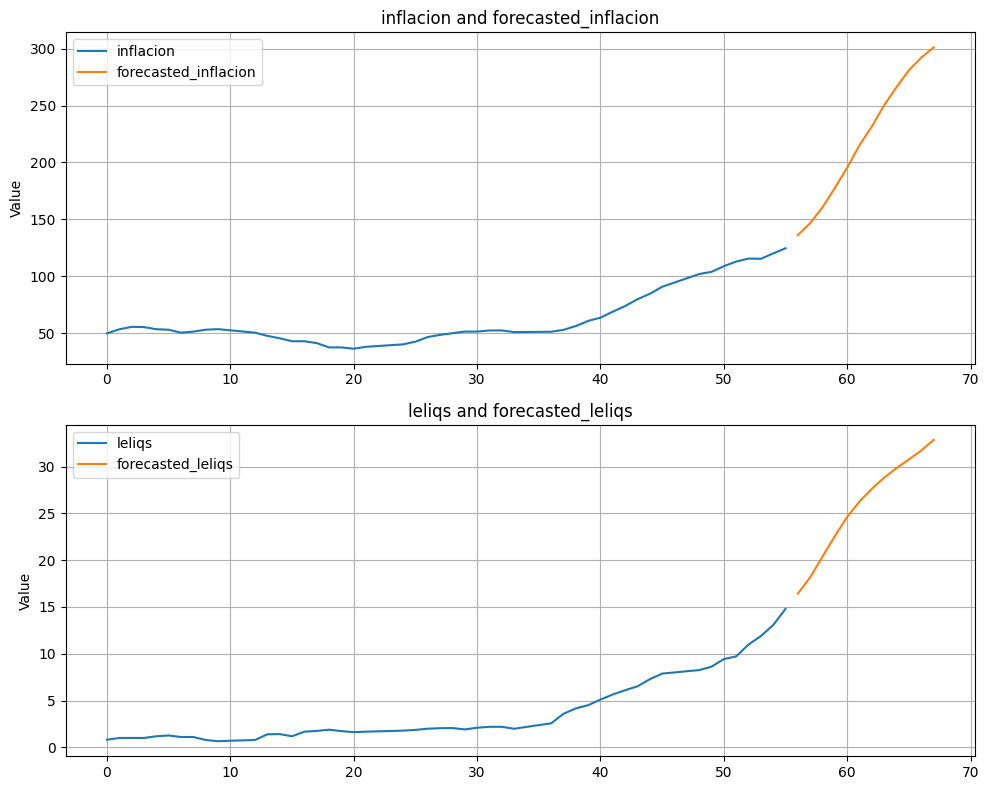

In [25]:
plot_future_forecast_with_history(df, general_config['features'])